<a href="https://colab.research.google.com/github/textnorms/address_text_norm/blob/master/T5_prefix_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [327]:
! nvidia-smi

Tue Jun 23 01:33:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [328]:
! rm -rf *
! git clone -q https://github.com/textnorms/address_text_norm.git
! git clone -q https://github.com/textnorms/date_text_norm.git

! pip install -q num2words transformers

In [329]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [330]:
!cp '/gdrive/My Drive/12 Semestre/IA376/IA376 - Atividades/Projeto Final/address_db.csv' ./address_text_norm/syntetic_data/address_csv/br_address_db.csv

# Libs

In [331]:
# Basics
import numpy as np
import pandas as pd
import random

# Synthetic data generator
from address_text_norm.syntetic_data import AddressTextGenerator
from date_text_norm.syntetic_data import DateTextGenerator
from date_text_norm.syntetic_data import RelativeDateTextGenerator

# PyTorch
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Matplot lib
import matplotlib.pyplot as plt

# To deal with text encoding issues
import unicodedata

### Deterministic experiments

In [332]:
manual_seed = 2357 # only primes, cuz I like
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Deterministic experiment, seed: 2357
Using device: cuda


# Config constants

In [333]:
# Dataset params - Here the zip codes are formatted in PT-BR
LANGUAGE_ADDRESS = 'br'
LANGUAGE_DATE = 'pt'

# Model params
MODEL_SZ = 't5-small' # 't5-base'
TOK = T5Tokenizer.from_pretrained(MODEL_SZ)
MAX_LEN_SRC  = 150
MAX_LEN_TRGT = 150


# Train params
BATCH_SZ = 16
N_EPOCHS = 5
WINDOW   = 7
NOISE    = 0.1
USE_PREFIX = True

# Dataset

In [334]:
pd.set_option('display.max_rows',70)

'''
  Instantiating addresses dataset generator
'''
addresses_gen = AddressTextGenerator(occurences_per_sample=10,
                                     text_noise_rate=NOISE,
                                     max_noise_occurences_per_sample=10,
                                     language=LANGUAGE_ADDRESS)

'''
  Instantiating absolute and incomplete dates dataset generator
'''
dates = DateTextGenerator(start_date='01/01/1921',
                          end_date='31/12/1950',
                          text_noise_rate=0.0,
                          language=LANGUAGE_DATE)

'''
  Instantiating relative dates dataset generator
'''
rel_dates = RelativeDateTextGenerator(text_noise_rate=0.0,
                                       max_noise_occurences_per_sample=3,
                                       samples_per_method=15,
                                       language=LANGUAGE_DATE)

'''
  Appending all datasets
'''
df = addresses_gen.generate_address_dataset()
df = df.append(rel_dates.generate_date_dataset(),ignore_index=True)
df = df.append(dates.generate_date_dataset(),ignore_index=True)

In [335]:
'''
  Fixing the Target Format for address
'''

df['Target Format'].replace(np.nan,'Address',inplace=True)

Text(0.5, 1.0, 'Per class value counts with non-unified dates')

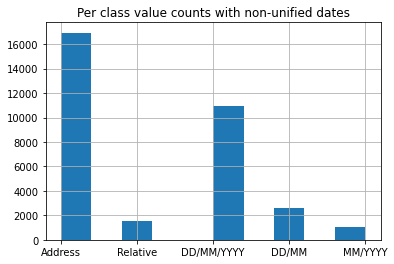

In [336]:
plot = df['Target Format'].hist()
plt.title('Per class value counts with non-unified dates')

In [337]:
'''
  Reindexing Input Patterns
'''
unique_target_formats = df['Target Format'].unique()

for  i,unique_target_format  in enumerate(unique_target_formats):

  if i>len(unique_target_formats)-2:
    break

  next_unique_target_format = unique_target_formats[i+1]

  a = df['Target Format'] == unique_target_format
  b = df['Target Format'] == next_unique_target_format
  
  print(unique_target_format,next_unique_target_format)

  max_pattern = df.loc[df['Target Format'] == unique_target_format]['Input Pattern'].max()

  df.loc[b,'Input Pattern'] = df.loc[b]['Input Pattern'] + max_pattern

Address Relative
Relative DD/MM/YYYY
DD/MM/YYYY DD/MM
DD/MM MM/YYYY


In [338]:
# df['New Pattern Index'] = df.loc[df['Target Format'] == 'Address']['Input Pattern']
df['Input Pattern'].value_counts()

1      802
22     794
11     791
8      787
16     781
      ... 
152     18
167     17
149     16
174     15
165     14
Name: Input Pattern, Length: 193, dtype: int64

In [339]:
'''
  Putting all dates in the same group
'''
df['Target Format'].replace('DD/MM','Date',inplace=True)
df['Target Format'].replace('DD/MM/YYYY','Date',inplace=True)
df['Target Format'].replace('MM/YYYY','Date',inplace=True)
df['Target Format'].replace('Relative','Date',inplace=True)

Text(0.5, 1.0, 'Per class value counts with unified dates')

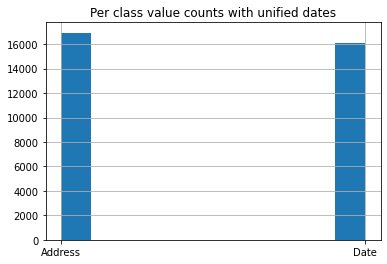

In [340]:
plot = df['Target Format'].hist()
plt.title('Per class value counts with unified dates')

In [341]:
df.head()

,Input Pattern,Noise Type,Input,Target,Target Format
0,6,N/A,Número 735 da Avenida Rodrigo Otávio 6200 no C...,"Avenida Rodrigo Otávio 6200, 735, Coroado, Manaus",Address
1,11,N/A,"Avenida Rodrigo Otávio 6200, Coroado, Manaus, AM","Avenida Rodrigo Otávio 6200, S/N, Coroado, Man...",Address
2,13,N/A,"Avenida Rodrigo Otávio 6200, 735, Sala 191, Co...","Avenida Rodrigo Otávio 6200, 735, Sala 191, Co...",Address
3,3,N/A,Altura do 735 na Avenida Rodrigo Otávio 6200 n...,"Avenida Rodrigo Otávio 6200, 735, Coroado, Manaus",Address
4,14,N/A,Apartamento 188 na altura do 735 na Avenida Ro...,"Avenida Rodrigo Otávio 6200, 735, Apartamento ...",Address


In [342]:
df.tail()

,Input Pattern,Noise Type,Input,Target,Target Format
33034,159,N/A,11 - 1950,11/1950,Date
33035,167,N/A,"11 mil, novecentos e cinquenta",11/1950,Date
33036,186,N/A,12/1950,12/1950,Date
33037,184,N/A,dez.1950,12/1950,Date
33038,179,N/A,12 . 1950,12/1950,Date


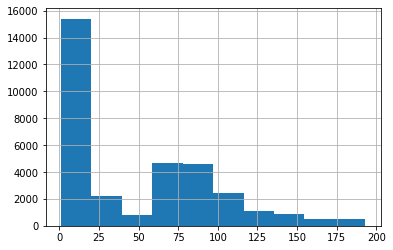

In [343]:
df['Input Pattern'].hist()

In [344]:
# Inspecting the relative dates dataset
df

,Input Pattern,Noise Type,Input,Target,Target Format
0,6,N/A,Número 735 da Avenida Rodrigo Otávio 6200 no C...,"Avenida Rodrigo Otávio 6200, 735, Coroado, Manaus",Address
1,11,N/A,"Avenida Rodrigo Otávio 6200, Coroado, Manaus, AM","Avenida Rodrigo Otávio 6200, S/N, Coroado, Man...",Address
2,13,N/A,"Avenida Rodrigo Otávio 6200, 735, Sala 191, Co...","Avenida Rodrigo Otávio 6200, 735, Sala 191, Co...",Address
3,3,N/A,Altura do 735 na Avenida Rodrigo Otávio 6200 n...,"Avenida Rodrigo Otávio 6200, 735, Coroado, Manaus",Address
4,14,N/A,Apartamento 188 na altura do 735 na Avenida Ro...,"Avenida Rodrigo Otávio 6200, 735, Apartamento ...",Address
...,...,...,...,...,...
33034,159,N/A,11 - 1950,11/1950,Date
33035,167,N/A,"11 mil, novecentos e cinquenta",11/1950,Date
33036,186,N/A,12/1950,12/1950,Date
33037,184,N/A,dez.1950,12/1950,Date


## Function to split the dataset

In [345]:
def split_data(df, test_size=0.2, verbose=True):
    l = list(set(df['Input Pattern'].values))
    num_test = int(len(l)*test_size)
    test_methods = [random.randint(1, len(l)) for _ in range(num_test)]
    print(test_methods)
    df_test = df[df['Input Pattern'].isin(test_methods)]
    print(df_test.shape)
    x_test = df_test.Input.values
    y_test = df_test.Target.values
    prefix_test = df_test['Target Format']

    df_train = df[~df['Input Pattern'].isin(test_methods)]

    x_train, x_val, y_train, y_val,prefix_train,prefix_val = train_test_split(
        df_train.Input.values,
        df_train.Target.values,
        df_train['Target Format'].values,
        shuffle=True, 
        test_size=test_size,
        random_state=manual_seed
        )
    if verbose:
        print(f'Address types of test set: {test_methods} with len: {len(test_methods)}')
        print(f'x_train: {len(x_train)}  --  y_train: {len(y_train)}\n\
x_val:   {len(x_val)}  --  y_val:   {len(y_val)}\n\
x_test:  {len(x_test)}  --  y_test:  {len(y_test)}')

    return x_train, prefix_train, y_train, x_val, prefix_val, y_val, x_test, prefix_test, y_test

# creating sets
x_train, prefix_train, y_train, x_val, prefix_val, y_val, x_test, prefix_test, y_test = split_data(df, 
                                                                                                test_size=0.25, 
                                                                                                verbose=True)

[99, 96, 77, 188, 1, 29, 93, 71, 35, 82, 139, 89, 151, 16, 64, 188, 157, 86, 186, 12, 162, 24, 140, 152, 25, 15, 86, 143, 137, 13, 87, 130, 53, 69, 39, 167, 165, 164, 166, 148, 70, 1, 121, 122, 189, 13, 148, 79]
(7959, 5)
Address types of test set: [99, 96, 77, 188, 1, 29, 93, 71, 35, 82, 139, 89, 151, 16, 64, 188, 157, 86, 186, 12, 162, 24, 140, 152, 25, 15, 86, 143, 137, 13, 87, 130, 53, 69, 39, 167, 165, 164, 166, 148, 70, 1, 121, 122, 189, 13, 148, 79] with len: 48
x_train: 18810  --  y_train: 18810
x_val:   6270  --  y_val:   6270
x_test:  7959  --  y_test:  7959


In [346]:
class AddressDataset(Dataset):
    def __init__(self, data, prefix, label, tokenizer, source_max_length, target_max_length):
        self.tokenizer = tokenizer
        self.data = data
        self.label = label
        self.prefix = prefix
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source = self.data[idx]
        target = self.label[idx]
        prefix = self.prefix[idx]

        source = unicodedata.normalize('NFD', source).encode('latin-1', 'xmlcharrefreplace').decode('latin-1')
        target = unicodedata.normalize('NFD', target).encode('latin-1', 'xmlcharrefreplace').decode('latin-1')


        if USE_PREFIX:
          source_str = f'{prefix}: {source} {self.tokenizer.eos_token}'
        else:
          source_str  = f'{source} {self.tokenizer.eos_token}'
        
        source_tokenized = self.tokenizer.encode_plus(
            source_str,
            max_length=self.source_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        target_tokenized = self.tokenizer.encode_plus(
            f'{target} {self.tokenizer.eos_token}',
            max_length=self.target_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        source_token_ids = source_tokenized['input_ids'].squeeze()
        source_mask = source_tokenized['attention_mask'].squeeze()
        target_token_ids = target_tokenized['input_ids'].squeeze()
        
        return source_token_ids, source_mask, target_token_ids

## Checking the AddressDataset class

In [347]:
dataset_debug = AddressDataset(
    x_train,
    prefix_train, 
    y_train,
    TOK,
    MAX_LEN_SRC,
    MAX_LEN_TRGT,
    )

dataloader_checking = DataLoader(
    dataset_debug, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0
    )

source_token_ids, source_mask, target_token_ids = next(iter(dataloader_checking))
print(f'source_token_ids:\n {source_token_ids} --- shape:{source_token_ids.shape}')
print(f'source_mask:\n {source_mask} --- shape:{source_mask.shape}')
print(f'target_token_ids:\n {target_token_ids} --- shape:{target_token_ids.shape}')

source_token_ids:
 tensor([[7678,   10, 2208,   18,   26, 2187,   51, 5702, 4481, 2884,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

## Datasets e Dataloaders

In [348]:
# datasets
ds_debug = AddressDataset(x_train[:BATCH_SZ], prefix_train[:BATCH_SZ],y_train[:BATCH_SZ], TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_train = AddressDataset(x_train, prefix_train, y_train, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_valid = AddressDataset(x_val, prefix_val, y_val, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_test  = AddressDataset(x_test, prefix_test, y_test, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)

print('Datasets len:')
print(f'len ds_debug: {len(ds_debug)}')
print(f'len ds_train: {len(ds_train)}')
print(f'len ds_valid: {len(ds_valid)}')
print(f'len ds_test:  {len(ds_test)}')

# dataloaders
dataloaders = {
    'debug': DataLoader(
         ds_debug,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'valid': DataLoader(
         ds_valid,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
    'test': DataLoader(
         ds_test,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
               }
# sanity check
print('\nDataloaders len (in batch):')
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}; dl_sizes

Datasets len:
len ds_debug: 16
len ds_train: 18810
len ds_valid: 6270
len ds_test:  7959

Dataloaders len (in batch):


{'debug': 1, 'test': 498, 'train': 1176, 'valid': 392}

In [349]:
# testando o dataloader 
source_token_ids, source_mask, target_token_ids = next(iter(dataloaders['debug']))

In [350]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_SZ)
    
    def forward(self, token_ids, att_mask, labels):
        outputs = self.model.forward(
            input_ids=token_ids, 
            attention_mask=att_mask,
            lm_labels=labels
            )
        return outputs[0] # loss
    
    @torch.no_grad()    
    def generate(self, token_ids, att_mask, max_len_target):
        predict = self.model.generate(
            input_ids=token_ids, 
            attention_mask=att_mask,
            max_length=max_len_target
            )
        return predict
    
    @torch.no_grad()  
    def generate_example(self, text_input, tokenizer, max_len_source=MAX_LEN_SRC):

        self.model.eval()
        
        example_tokenized = tokenizer.encode_plus(
            f'{text_input} {tokenizer.eos_token}',
            max_length=max_len_source,
            pad_to_max_length=True,
            return_tensors='pt')
            
        example_token_ids = example_tokenized['input_ids']
        example_mask = example_tokenized['attention_mask']

        predicted_example = self.model.generate(
            input_ids=example_token_ids.to(device), 
            attention_mask=example_mask.to(device),
            max_length=MAX_LEN_TRGT
            )

        self.model.train()

        out_text = [tokenizer.decode(text) for text in predicted_example]
        
        return out_text

## Train and evaluation functions

In [351]:
# acc metric for text inputs
def acc_in_text(trues, preds): 
    acc = []
    for d in zip(trues, preds):
        if d[0] == d[1]:
            acc.append(1)
        else:
            acc.append(0)
    return acc # bool

def train(model, device, train_loader, optimizer):
    loss_train = []
    model.train()
    for source_token_ids, source_mask, target_token_ids in train_loader:
        optimizer.zero_grad()
        loss = model(
            source_token_ids.to(device), 
            source_mask.to(device), 
            target_token_ids.to(device)
            )
        
        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    
    train_losses = sum(loss_train) / len(loss_train)
  
    return train_losses

def evaluate_fn(model, device, val_loader, max_len=MAX_LEN_TRGT):
    loss_val, all_acc, all_preds, all_trues = [], [], [], []
    model.eval()
    for source_token_ids, source_mask, target_token_ids in val_loader:
        predicted_ids = model.generate(
            source_token_ids.to(device), 
            source_mask.to(device),
            max_len
            )
        
        preds = [TOK.decode(t) for t in predicted_ids]
        trues = [TOK.decode(t) for t in target_token_ids]
        acc = acc_in_text(trues, preds)
        all_acc.extend(acc)
        all_trues.extend(trues)
        all_preds.extend(preds)
        
        # val loss   
        loss = model(
        source_token_ids.to(device), 
        source_mask.to(device), 
        target_token_ids.to(device)
        )
        loss_val.append(loss.item())
    
    val_losses = sum(loss_val) / len(loss_val)
    
    return val_losses, np.array(all_acc).mean(), all_trues, all_preds

# Overfit in one batch 
- dataloader debug

In [352]:
overfit = True

if overfit:

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    deterministic() 

    model = Net().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    # -----------------------------------------------------------------------------
    start.record()
    for step in range(1, 1001):
        samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
        loss_t = train(model, device, dataloaders['debug'], optimizer)
        loss,acc, trues, preds = evaluate_fn(model, device, dataloaders['debug'])
        if step == 1:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
        if step % 100 == 0:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
            print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')
        if acc>= 0.99:
          print('The model has overfitted! Breaking the loop :)')
          break
    end.record()
    torch.cuda.synchronize()    
    # -----------------------------------------------------------------------------

    print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')
    del model

Deterministic experiment, seed: 2357



[Epoch: 1/1000] | Train Loss: 10.708 -- Acc: 0.062
[Epoch: 100/1000] | Train Loss: 0.574 -- Acc: 0.000
  Trues: ['07/10/1927', 'Rua Sa&#771;o Rufino, 2141, Pajuc&#807;ara, Natal, RN', 'Avenida Segunda Radial, 9178, Torre 3 - Apartamento 142, Vila Redenc&#807;a&#771;o, Goia&#770;nia', 'Rua Sebastia&#771;o Gomes de Azevedo, 3417, Sala 191, Santo Andre&#769;, Divino&#769;polis', '49y', 'Rua Glorinha, 9932, Torre 10 - Sala 3, Casa Amarela, Recife, PE', '22/12/1939']
  Preds: ['', '', '', '', '', '', '']
[Epoch: 200/1000] | Train Loss: 0.267 -- Acc: 0.000
  Trues: ['06/08', 'Rua Sa&#771;o Jero&#770;nimo da Serra, S/N, Box 81,Santa Ca&#770;ndida, Curitiba, PR', 'Rua Raimundo de Paiva Gadelha, 1605, Hangar 20, Centro, Sousa', 'Rua Sebastia&#771;o Gomes de Azevedo, 3417, Sala 191, Santo Andre&#769;, Divino&#769;polis', '22/12/1939', 'Quadra ACSU SO 100 Avenida Joaquim Teotonio Segurado, 1428, Plano Diretor Sul, Palmas, TO', 'Rua Sa&#771;o Rufino, 2141, Pajuc&#807;ara, Natal, RN']
  Preds: [''

# Training 

In [353]:
try:
  del model
except:
  print('Model already erased, starting a new one!')
  
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
deterministic() 

model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=7e-5)

N_EPOCHS = 10

# ---------------------------------------------------------------------------------
start.record()
for step in range(1, N_EPOCHS+1):
    samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
    loss_t = train(model, device, dataloaders['train'], optimizer)
    loss_v, acc, trues, preds = evaluate_fn(model, device, dataloaders['valid'])
    print(f'[Epoch: {step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_t:.3f} -- Valid Loss: {loss_v:.3f} -- Acc: {acc:.3f}')
    print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Model already erased, starting a new one!
Deterministic experiment, seed: 2357
[Epoch: 1/10] | Train Loss: 0.293 -- Valid Loss: 0.043 -- Acc: 0.380
  Trues: ['Travessa Lauro Sodre&#769; 130, 6674, Centro, Mocajuba', 'Rua Abrolhos, 1624, Santa Mo&#770;nica, Guarapari', 'Rua Planaltina, 5401, Marambaia (Manilha), Itaborai&#769;, RJ, 24859380', 'Rua D, S/N, Piranema, Serope&#769;dica, RJ', '16/02', 'Rua Pioneiro Benedito de Oliveira Franco, 5173, Jardim Paulista III, Maringa&#769;, PR', '25/10/1925']
  Preds: ['Altura do 6674 na Travessa Lauro Sodre&#769; 130, Centro, Mocajuba', 'Rua Abrolhos, 1624, Santa Mo&#770;nica, Guarapari', 'Rua Planaltina, 5401, Marambaia (Manilha), Itaborai&#769;, RJ, 24859380', 'Rua D, S/N, Piranema, Serope&#769;dica, RJ', '16/02', 'Rua Pioneiro Benedito de Oliveira Franco, 5173, Jardim Paulista III, Maringa&#769;, PR', '25/02/1925']
[Epoch: 2/10] | Train Loss: 0.048 -- Valid Loss: 0.028 -- Acc: 0.584
  Trues: ['Travessa Lauro Sodre&#769; 130, 6674, Centro, Moca

# Test

In [354]:
# ---------------------------------------------------------------------------------
start.record()

samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
loss, acc, trues, preds = evaluate_fn(model, device, dataloaders['test'])
print(f'Loss: {loss:.3f} -- Acc: {acc:.3f}')
print(f' Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Test time: {start.elapsed_time(end)/1000/60 :.3f} min.')

KeyError: ignored

# Evaluating types for a same address

Given a sample address, this section evaluates wich is the accuracy considering all the formats.




In [355]:
def evaluate_for_a_same_address(logradouro,numero,complemento,
                bairro,cidade,uf,cep, model=model,tokenizer=TOK,
                verbose=True):
  '''
    Given a specific address, returns the accuracy in all evaluated types.
    Also prints results per sample.
  '''

  results = []
  
  examples = addresses_gen.generate_demo(logradouro,numero,complemento,
                bairro,cidade,uf,cep)


  for x,target in zip(examples['Generated Text'],examples['Origin Sample']):

    prediction = model.generate_example(x,TOK)[0]

    results.append(prediction == target)

    if verbose:
      print(f'Entrada: {x} -- Target: {target} --- Previsto: {prediction} --- {prediction == target}')

  if verbose:
    print(f'Total accuracy: {np.mean(results)}')

  return np.mean(results)

In [356]:
'''
  Using our faculty address as a sample
  Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852
'''
evaluate_for_a_same_address('Avenida Albert Einstein', '400', '','Cidade Universitária',
                         'Campinas', 'SP', '13083852')

Entrada: 400, Avenida Albert Einstein, Cidade Universitária, Campinas, SP, 13083852 -- Target: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 --- Previsto: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 --- True
Entrada: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 -- Target: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 --- Previsto: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 --- True
Entrada: Altura do 400 na Avenida Albert Einstein no Cidade Universitária de Campinas -- Target: Avenida Albert Einstein, 400, Cidade Universitária, Campinas --- Previsto: Avenida Albert Einstein, 400, Cidade Universitária, Campinas --- True
Entrada: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, São Paulo, 13083852 -- Target: Avenida Albert Einstein, 400, Cidade Universitária, Campinas, SP, 13083852 --- Previsto: Avenida Albert Einstein, 400, C

1.0

# The End